In [1]:
# CONVERSION PERFORMS THE ACTUAL VOICE CONVERSION THAT HAPPENS AFTER A MODEL IS TRAINED,
# SO WE'VE BEEN PROVIDED WITH A PRETRAINED AUTOVC MODEL TO DEMONSTRATE THIS

import os
import pickle
import torch
import numpy as np
from math import ceil
from model_vc import Generator

def pad_seq(x, base=32):
    len_out = int(base * ceil(float(x.shape[0])/base))
    len_pad = len_out - x.shape[0]
    assert len_pad >= 0
    return np.pad(x, ((0,len_pad),(0,0)), 'constant'), len_pad

device = 'cuda:0'
G = Generator(32,256,512,32).eval().to(device)

# pretrained autovc model loaded into G model
g_checkpoint = torch.load('autovc.ckpt')
G.load_state_dict(g_checkpoint['model'])

################### Paper - Section 4.2. The Content Encoder #########################################################

# metadata contains original audio data and corresponding speaker embedding?
metadata = pickle.load(open('metadata.pkl', "rb"))

# spect_vc collects spectrogram information to be used later for spec2wav conversion via wavnet model
spect_vc = []

x_org_list = []

# each sbmt_i has a speaker ID, a speaker embedding, and a spectrogram
for sbmt_i in metadata:
    
    # x origin - 80Mel spectrogram
    x_org = sbmt_i[2]
    x_org_list.append( ('{}'.format(sbmt_i[0]), x_org) )
    x_org, len_pad = pad_seq(x_org)
    # utterance origin is just padded spec in tensor form
    uttr_org = torch.from_numpy(x_org[np.newaxis, :, :]).to(device)
    # speaker embedding 
    emb_org = torch.from_numpy(sbmt_i[1][np.newaxis, :]).to(device)

    # for each entry in metadata, use it as the embedding target and use this in G
    for sbmt_j in metadata:
        # embedding target represents S2 in the paper - the embedding provided by a pretrained Speaker Encoder
        # I guess this converts each utterance from the data so that it matches the utterance of every speaker
        # So if there were 4 utterances with different speakers, then this code will generate 4*4=16 conversions
        emb_trg = torch.from_numpy(sbmt_j[1][np.newaxis, :]).to(device)
        
        # as this is conversion not training, no backprop/gradientCommunication needed here
        with torch.no_grad():
            # x_identic_psnt = target utterance, produced by the Generator
            # Generator is fed an utterance and speaker 
            _, x_identic_psnt, _ = G(uttr_org, emb_org, emb_trg)
            
        if len_pad == 0:
            # utterance target is the converted speech
            uttr_trg = x_identic_psnt[0, 0, :, :].cpu().numpy()
        else:
            uttr_trg = x_identic_psnt[0, 0, :-len_pad, :].cpu().numpy()
        # utterance is saved in a list, along with source and target ID
        spect_vc.append( ('{}x{}'.format(sbmt_i[0], sbmt_j[0]), uttr_trg) )
        
        
with open('results.pkl', 'wb') as handle:
    pickle.dump(spect_vc, handle)

with open('x_org.pkl', 'wb') as howdy:
    pickle.dump(x_org_list, howdy)

print('done')

done


In [2]:
import os
import pickle
import torch
import numpy as np
from math import ceil
from model_vc import Generator

In [3]:
metadata = pickle.load(open('metadata.pkl', "rb"))

In [31]:
group = 3
instance = 0

print('len(metadata)', len(metadata))
print('len(metadata[{0}])'.format(group), len(metadata[group]))
print('metadata[{0}]'.format(group), metadata[group])
print('len(metadata[{0}][{1}])'.format(group,instance), len(metadata[group][instance]))
print('metadata[0][0]'.format(group,instance), metadata[group][instance])

len(metadata) 4
len(metadata[3]) 3
metadata[3] ['p270', array([ 6.19222037e-02,  1.16684157e-02, -4.22575586e-02,  5.51224947e-02,
        1.50849177e-02, -2.69684643e-02, -5.67021444e-02, -5.77663407e-02,
        1.83176864e-02, -3.65749151e-02,  3.00049074e-02, -4.02177498e-02,
       -4.87555796e-03,  3.10393479e-02, -7.82383606e-03, -3.96691188e-02,
        7.25774700e-03, -4.31945696e-02,  4.18364033e-02,  9.94609948e-03,
        4.09234799e-02,  2.48512384e-02,  1.53806685e-02,  8.12757015e-03,
        4.75192778e-02, -4.56583425e-02,  2.11870465e-02,  2.17956565e-02,
        4.22006510e-02,  1.08999740e-02,  7.03486428e-02, -2.31808685e-02,
        3.21317315e-02,  3.14271674e-02,  1.38234599e-02, -2.57808380e-02,
       -3.51578593e-02, -9.93499905e-03, -9.62212011e-02, -2.63237059e-02,
       -1.23301614e-02,  4.64690886e-02, -5.65508902e-02,  2.19537243e-02,
        5.47900610e-02, -7.80382156e-02,  3.92911658e-02,  5.47564551e-02,
       -4.16242816e-02,  7.47532994e-02,  2.

In [ ]:
meta

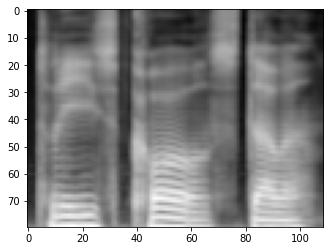

In [12]:
results = pickle.load(open('results.pkl', "rb"))
len(results[0][1])

img_array = results[15][1]
img_array = np.rot90(img_array)

from matplotlib import pyplot as plt

plt.imshow(img_array, cmap='gray')
plt.show()

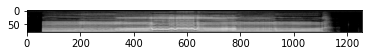

In [6]:
import numpy as np

source_spmel = np.load('./Brendan_spmel/225subfolder/f1_arpeggios_belt_c_a.npy')

img_array = source_spmel
img_array = np.rot90(img_array)

from matplotlib import pyplot as plt

plt.imshow(img_array, cmap='gray')
plt.show()

In [7]:
img_array.shape

(80, 1255)

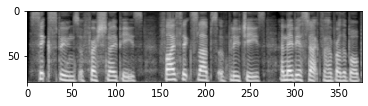

In [3]:
source_spmel = np.load('./spmel/p225/p225_003.npy')

img_array = source_spmel
img_array = np.rot90(img_array)

from matplotlib import pyplot as plt

plt.imshow(img_array, cmap='gray')
plt.show()

In [5]:
img_array.shape

(80, 376)

In [28]:
print(len(spect_vc))
spect_vc[0][1].shape

16


(90, 80)

In [31]:
print(len(metadata))
print(len(metadata[0])) #id, spec, speaker embedding
metadata[0][2].shape

4
3


(90, 80)

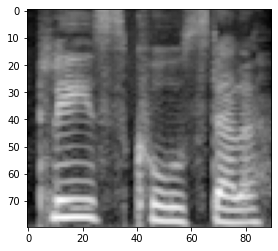

In [32]:
img_array = metadata[0][2]
img_array = np.rot90(img_array)

from matplotlib import pyplot as plt

plt.imshow(img_array, cmap='gray')
plt.show()

In [3]:
metadata[0]


['p225',
 array([-2.92885415e-02,  1.67739280e-02,  6.42375797e-02,  5.12384847e-02,
         8.77934247e-02, -4.05867286e-02,  1.08849108e-02,  2.06673276e-02,
        -8.39690343e-02,  1.48199843e-02,  3.82344425e-02,  1.12243919e-02,
         4.62971367e-02,  1.66661311e-02, -5.78785129e-02,  3.60288732e-02,
         1.92339886e-02,  9.17971320e-03,  2.74707917e-02, -5.48039749e-02,
         2.50798557e-02,  4.66737375e-02, -6.14981353e-03,  3.88026945e-02,
         5.68139665e-02, -7.33052716e-02,  2.30920967e-02, -1.04292825e-01,
        -2.61898227e-02,  3.02257240e-02, -3.02889403e-02,  3.63447554e-02,
        -4.97230627e-02,  1.57715172e-01, -3.93295921e-02,  5.51161245e-02,
         4.64604087e-02, -4.59927395e-02, -4.82378080e-02, -3.81431282e-02,
         3.91379185e-02,  4.59317304e-02, -1.55072343e-02, -1.67513415e-02,
        -5.09507731e-02, -5.08496165e-02, -2.25679334e-02,  2.63878461e-02,
        -1.26611767e-02, -2.49883570e-02,  3.02621610e-02, -2.48487398e-04,
   

In [12]:
metadata[0][2].shape

(90, 80)

In [10]:
metadata = pickle.load(open('metadata.pkl', "rb"))


In [13]:
type(metadata)

list

In [2]:
import pickle
spect_vc = pickle.load(open('results.pkl', 'rb'))

In [20]:
spect_vc[0][1][:int(len(spect_vc[0][1])/2)]

(791, 80)

In [11]:
int(spect_vc[0][1])/2)

SyntaxError: invalid syntax (<ipython-input-11-088ea2872ebc>, line 1)